## Cassava Leaf Disease Classification:

# Best Keras CNN TPU

![Cassava](https://cdn.hauschka.com/images/system/plant_library/hauschka/manihot-esculenta-crantz-gross.jpg)

### The final part of this [Cassava Leaf Disease: Keras CNN baseline](https://www.kaggle.com/maksymshkliarevskyi/cassava-leaf-disease-keras-cnn-baseline) and this [Cassava Leaf Disease: Keras CNN prediction](https://www.kaggle.com/maksymshkliarevskyi/cassava-leaf-disease-keras-cnn-prediction) notebooks.

### Some models and weights stored in this dataset: [Cassava Leaf Disease Models](https://www.kaggle.com/maksymshkliarevskyi/cassava-leaf-disease-models)

#### Here you'll find:
* examples of ImageDataGenerator work;
* my best experiments with EfficientNet CNNs;
* visualizations of CNN intermediate activations;
* something else interesting in the future.

#### Ideas for future improvements:
* try various image sizes;
* try various batch sizes;
* experiments with learning rate;
* experiments with data augmentation;
* other.

#### I am grateful to François Cholet for the book "Deep Learning with Python", wherefrom I borrowed some useful techniques.

## Loading packages

In [1]:
!pip install --quiet /kaggle/input/kerasapp
!pip install --quiet /kaggle/input/effnetmy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from kaggle_datasets import KaggleDatasets
import efficientnet.tfkeras as efn

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json
from tensorflow.keras.preprocessing import image

In [3]:
# # TPU or GPU detection
# # Detect hardware, return appropriate distribution strategy
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print(f'Running on TPU {tpu.master()}')
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy()

# AUTO = tf.data.experimental.AUTOTUNE
# REPLICAS = strategy.num_replicas_in_sync
# print(f'REPLICAS: {REPLICAS}')

## Work directory

In [4]:
WORK_DIR = '../input/cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

# First look at the data

In [5]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train_images"))))

Train images: 21397


In [6]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [7]:
# Data
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
labels = np.transpose([train_labels['label']])
train_images = WORK_DIR + "/train_images/" + train_labels['image_id']

ss = pd.read_csv(os.path.join(WORK_DIR, 'sample_submission.csv'))
test_images = WORK_DIR + "/test_images/" + ss['image_id']

train_labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


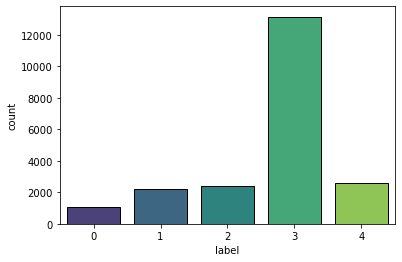

In [8]:
sns.countplot(train_labels.label, edgecolor = 'black',
              palette = sns.color_palette("viridis", 5))
plt.show()

## Some photos of "0": "Cassava Bacterial Blight (CBB)"

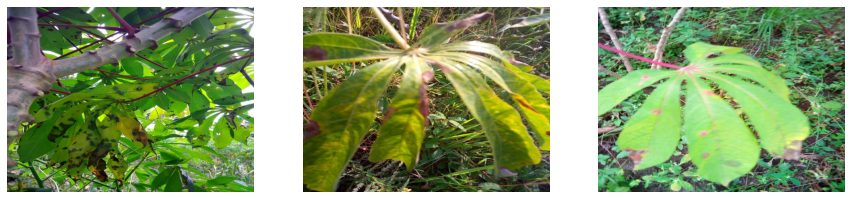

In [9]:
sample = train_labels[train_labels.label == 0].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

## Some photos of "1": "Cassava Brown Streak Disease (CBSD)"

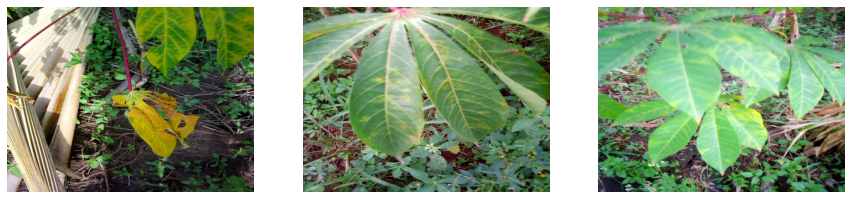

In [10]:
sample = train_labels[train_labels.label == 1].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

## Some photos of "2": "Cassava Green Mottle (CGM)"

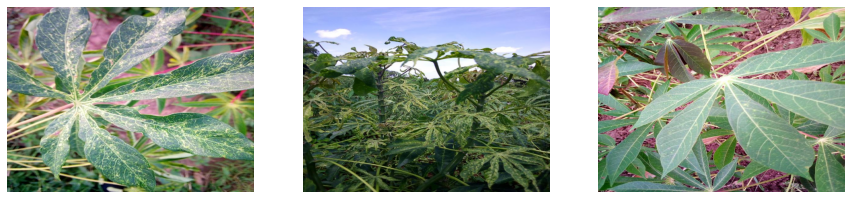

In [11]:
sample = train_labels[train_labels.label == 2].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

## Some photos of "3": "Cassava Mosaic Disease (CMD)"

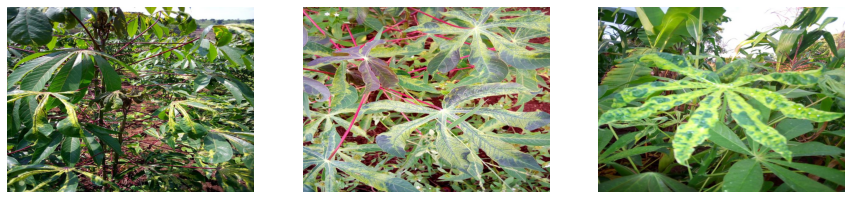

In [12]:
sample = train_labels[train_labels.label == 3].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

## Some photos of "4": "Healthy"

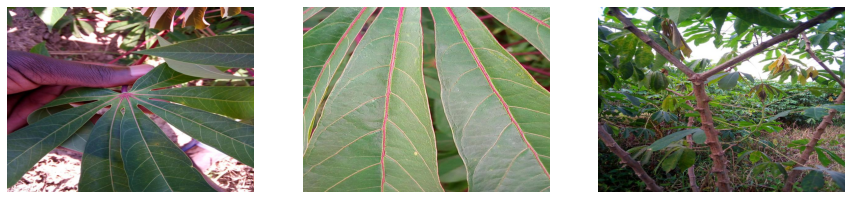

In [13]:
sample = train_labels[train_labels.label == 4].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

# Preparation for modeling

In [14]:
# Main parameters
BATCH_SIZE = 8 * 1
STEPS_PER_EPOCH = len(train_labels) * 0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels) * 0.2 / BATCH_SIZE
EPOCHS = 30
TARGET_SIZE = 550

In [15]:
# https://www.kaggle.com/xhlulu/ranzcr-efficientnet-b3-gpu-starter

def build_decoder(with_labels = True,
                  target_size = (TARGET_SIZE, TARGET_SIZE), 
                  ext = 'jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels = 3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels = 3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels = True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
#         img = tf.image.adjust_brightness(img, 0.1)
#         img = tf.image.random_contrast(img, 0.8, 1.2)
#         img = tf.image.random_saturation(img, 0.8, 1.2)
        
        p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
        p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
        p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
        p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
        p_crop = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
        if p_rotate > .75:
            img = tf.image.rot90(img, k = 3) # rotate 270º
        elif p_rotate > .5:
            img = tf.image.rot90(img, k = 2) # rotate 180º
        elif p_rotate > .25:
            img = tf.image.rot90(img, k = 1) # rotate 90º
            
        if p_pixel_1 >= .5:
            img = tf.image.random_saturation(img, lower = 0.7, upper = 1.3)
        if p_pixel_2 >= .5:
            img = tf.image.random_contrast(img, lower = 0.7, upper = 1.3)
        if p_pixel_3 >= .5:
            img = tf.image.random_brightness(img, max_delta = 0.1)
        
        if p_crop > .7:
            if p_crop > .9:
                img = tf.image.central_crop(img, central_fraction=.7)
            elif p_crop > .8:
                img = tf.image.central_crop(img, central_fraction=.8)
            else:
                img = tf.image.central_crop(img, central_fraction=.9)
        elif p_crop > .4:
            crop_size = tf.random.uniform([], int(TARGET_SIZE * .8), TARGET_SIZE, dtype = tf.int32)
            img = tf.image.random_crop(img, size = [crop_size, crop_size, 3])
        
        img = tf.image.resize(img, size = [TARGET_SIZE, TARGET_SIZE])
        
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels = None, bsize = 32, cache = True,
                  decode_fn = None, augment_fn = None,
                  augment = True, repeat = True, shuffle = 1024, 
                  cache_dir = ""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls = AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls = AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset


# Visualization of CNN intermediate activations
def activation_layer_vis(img, activation_layer = 0, layers = 10):
    layer_outputs = [layer.output for layer in model.layers[:layers]]
    activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(img)
    
    rows = int(activations[activation_layer].shape[3] / 3)
    cols = int(activations[activation_layer].shape[3] / rows)
    fig, axes = plt.subplots(rows, cols, figsize = (15, 15 * cols))
    axes = axes.flatten()
    
    for i, ax in zip(range(activations[activation_layer].shape[3]), axes):
        ax.matshow(activations[activation_layer][0, :, :, i], cmap = 'viridis')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def all_activations_vis(img, layers = 10):
    layer_outputs = [layer.output for layer in model.layers[:layers]]
    activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(img)
    
    layer_names = []
    for layer in model.layers[:layers]: 
        layer_names.append(layer.name) 

    images_per_row = 3
    for layer_name, layer_activation in zip(layer_names, activations): 
        n_features = layer_activation.shape[-1] 

        size = layer_activation.shape[1] 

        n_cols = n_features // images_per_row 
        display_grid = np.zeros((size * n_cols, images_per_row * size)) 

        for col in range(n_cols): 
            for row in range(images_per_row): 
                channel_image = layer_activation[0, :, :, col * images_per_row + row] 
                channel_image -= channel_image.mean() 
                channel_image /= channel_image.std() 
                channel_image *= 64 
                channel_image += 128 
                channel_image = np.clip(channel_image, 0, 255).astype('uint8') 
                display_grid[col * size : (col + 1) * size, 
                             row * size : (row + 1) * size] = channel_image 
        scale = 1. / size 
        plt.figure(figsize=(scale * 5 * display_grid.shape[1], 
                            scale * 5 * display_grid.shape[0])) 
        plt.title(layer_name) 
        plt.grid(False)
        plt.axis('off')
        plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

In [16]:
#Train test split
# (train_img, valid_img, 
#  train_labels, valid_labels) = train_test_split(train_images, labels, 
#                                                 train_size = 0.8, 
#                                                 random_state = 0)

In [17]:
# Tensorflow datasets
# train_df = build_dataset(
#     train_img, train_labels, bsize = BATCH_SIZE, 
#     cache = True)

# valid_df = build_dataset(
#     valid_img, valid_labels, bsize = BATCH_SIZE, 
#     repeat = False, shuffle = False, augment = False, 
#     cache = True)

test_df = build_dataset(
    test_images, bsize = 1, repeat = False, 
    shuffle = False, augment = False, cache = False)

In [18]:
test_df

<PrefetchDataset shapes: (None, 550, 550, 3), types: tf.float32>

In [19]:
# def create_model():
#     conv_base = efn.EfficientNetB7(include_top = False, weights = 'imagenet',
#                                    input_shape = (TARGET_SIZE, TARGET_SIZE, 3))
#     model = conv_base.output
#     model = layers.GlobalAveragePooling2D()(model)
#     model = layers.Dropout(0.3)(model)
#     model = layers.Dense(5, activation = "softmax")(model)
#     model = models.Model(conv_base.input, model)

#     model.compile(optimizer = Adam(lr = 0.00025),
#                   loss = "sparse_categorical_crossentropy",
#                   metrics = ['sparse_categorical_accuracy'])
#     return model

In [20]:
model_0 = models.load_model('../input/best-keras-tpu/EffNetB4_550_TPU_0.h5')
model_1 = models.load_model('../input/best-keras-tpu/EffNetB4_550_TPU_1.h5')
model_2 = models.load_model('../input/best-keras-tpu/EffNetB4_550_TPU_2.h5')
model_3 = models.load_model('../input/best-keras-tpu/EffNetB4_550_TPU_3.h5')
model_4 = models.load_model('../input/best-keras-tpu/EffNetB4_550_TPU_4.h5')
models = [model_0, model_1, model_2, model_3, model_4]

In [21]:
# print('Our EfficientNet CNN has %d layers' %len(model.layers))

In [22]:
FOLDS = 5
preds = np.zeros((len(ss), 5))

for model in models:
    preds += model.predict(test_df) / FOLDS

ss['label'] = np.argmax(preds, axis = -1)
ss.to_csv('submission.csv', index = False)
ss

,image_id,label
0,2216849948.jpg,4


## WORK IN PROGRESS...